<h1>Does a job training program improve the earnings of disadvantaged workers?</h1>

In [3]:
# Silent warnings
import warnings
warnings.filterwarnings("ignore")

# Core
import numpy as np
import scipy
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pylab

# Data
import pandas as pd
from sklearn import tree
from sklearn import metrics
from sklearn import neighbors
from sklearn import ensemble


# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style('darkgrid')
plt.style.use('ggplot')

<h2>Introduction</h2>

<p><strong>Business Context.</strong> In the 1980s, Robert Lalonde conducted a study to evaluate the effects of training programs on labour workers. He observed the characteristic background data of the individuals involved. Several of them were selected for enrollment in the job training program (the National Supported Work Demonstration). The training program specifically targeted unemployed women, ex-drug addicts, ex-criminal offenders, and high school dropouts.</p>
<p><img src="data/trainingfailsmain.jpg" width="550" alt="Labour Training"></p>
<p>The Department of Labor is interested in digging deeper into this data and coming up with some actionable insights in order to raise the earnings of disadvantaged workers. They have contracted you as a data science consultant to assist them with this task.</p>
<p><strong>Business Problem.</strong> Your goal is to evaluate <strong>whether the job training program <em>causes</em> the earnings of disadvantaged workers to go up</strong>.</p>
<p><strong>Analytical Context.</strong> In this case we will continue our discussion of causal inference. We will study the importance of covariate balance and explore how to perform matching to get this balance. We will leverage a lot of the new classification models we have learned for this purpose.</p>

<h2>Examining the data</h2>
<p>The Lalonde dataset provides information on annual income for workers who enroll in the training workshop and those who did not enroll in the year subsequent to training. The outcome of interest is <code>re78</code> in which we want to know if there was an increase in earnings in 1978:</p>
<ol>
<li><strong>age</strong>: age in years</li>
<li><strong>educ</strong>: years of schooling</li>
<li><strong>black</strong>: indicator variable for blacks</li>
<li><strong>hisp</strong>: indicator variable for Hispanics</li>
<li><strong>married</strong>: indicator variable for martial status</li>
<li><strong>nodegr</strong>: indicator variable for high school diploma</li>
<li><strong>re74</strong>: real earnings in 1974</li>
<li><strong>re75</strong>: real earnings in 1975</li>
<li><strong>re78</strong>: real earnings in 1978 - this is the outcome of interest</li>
<li><strong>treat</strong>: an indicator variable for treatment status</li>
</ol>

In [4]:
lalonde_df = pd.read_csv('lalonde.csv', index_col=0)
lalonde_df.head()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460
NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940
NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500
NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460
NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899


<h3>Exercise 1:</h3>
<h4>1.1</h4>
<p>Provide summary statistics for all the variables in the dataset. What can you say about the average income of the population throughout the years? What percentage of the population saw a decrease in income from 1974 to 1975? What do you think happened in 1975?</p>

**Answer.**
## It descrease 52% in income from 1974 to 1975. I think in 1975, the financial crisis happened, so it will increase the unemployement rate. Therefore, the income average will be descreased significantly.

-------

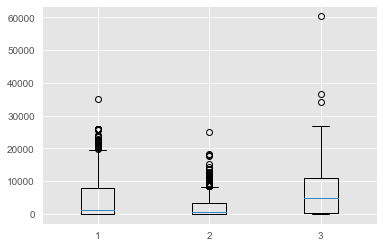

In [5]:
plt.boxplot(lalonde_df[['re74','re75','re78']])

plt.show()

In [6]:
a1=lalonde_df['re74'].mean()
a2=lalonde_df['re75'].mean()
(a1-a2)/a1

0.5205889454355784

<h4>1.2</h4>
<p>What percentage of the workers in our dataset are in the treatment group? Find the difference in means and medians of earnings between the control group and the treatment group. Is the difference of means statistically significant?</p>
<p><strong>Note:</strong> Remember that the <em>treatment and control groups</em> correspond to the sets of workers that were enrolled and not enrolled in the job training program, respectively. We can check if a worker is part of the treatment group by simply checking the value of the  <code>treat</code> column.</p>

**Answer.**

## The difference between two groups are significant in year 74,75, but not significant in year 78

-------

In [7]:
from matplotlib.widgets import Slider, Button, RadioButtons
from scipy import interp
from scipy.optimize import fsolve
from scipy.stats import chi2_contingency, ttest_ind
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
import math

In [8]:


a=lalonde_df[lalonde_df['treat']==1]['re75']
b=lalonde_df[lalonde_df['treat']==0]['re75']
T,p=ttest_ind(a,b)
p

0.0012234443948498416

In [9]:
a=lalonde_df[lalonde_df['treat']==1]['re74']
b=lalonde_df[lalonde_df['treat']==0]['re74']
T,p=ttest_ind(a,b)
p

3.464585257757616e-10

In [10]:
a=lalonde_df[lalonde_df['treat']==1]['re78']
b=lalonde_df[lalonde_df['treat']==0]['re78']
T,p=ttest_ind(a,b)
p

0.3342496685909654

<h4>1.3</h4>
<p>Does your previous result mean that the treatment had a negative impact? Why or why not?</p>

**Answer.**

In [11]:
## No, it does not. In year 78, there are not significant between two groups, 
## even the average of treatment group is smaller than the non treatment groups.
## The conclustion from the above results is that there is no difference between

## between treatment groups and non treatment groups

-------

## Assessing balance between the control group and the treatment group

Suppose we want to assess whether balance has been achieved for a particular feature $x = age$. That is, we would like to check whether the treatment and control groups have similar distributions of ages. We can look at **Standardized Mean Differences (SMD)**, which is calculated as follows: let $(\bar{x}_t,s_t^2)$ and $(\bar{x}_c, s_c^2)$ denote the mean and variance corresponding to the treatment and control groups of the particular feature of interest. Then, the SMD is defined as the value:

$$\mathrm{SMD}(x)=\frac{\bar{x}_{t}-{\bar{x}_{c}}}{\sqrt{\frac{s^{2}_{t} + s^{2}_{c}}{2}}}.$$

We can calculate the SMD for every feature. If our calculated SMD is 1, then that means there is a 1 standard deviation difference in means. The benefit of having standard deviation in the denominator is that this number becomes insensitive to the scale of the feature. 

After computing this measurement for all of our features, there is a rule of thumb that is commonly used to determine whether that feature is balanced or not (similar to the idea of using 0.05 as a threshold for $p$ - values):

1. **SMD < 0.1**: We say that the feature is balanced. In general, for a **randomized trial**, the SMD for all of the covariates should typically fall into this bucket.
2. **SMD is between 0.1 and 0.2**:  Not necessarily balanced, but small enough that people are usually not too worried about them. Sometimes, even after performing matching, there might still be a few covariates whose SMD falls in this range.
3. **SMD > 0.2**: Values that are greater than this threshold are considered seriously imbalanced.

<h3>Exercise 2:</h3>
<h4>2.1</h4>
<p>Assess covariate balance between the treatment and control groups. What features (covariates) are imbalanced between the control group and the treatment group in this dataset?</p>

**Answer.**

## Black is the imbalanced between control and treatment group.

-------

In [12]:
diff=lalonde_df.groupby(['treat']).agg(['mean','var'])
diff

age                   educ               black            \
            mean         var       mean       var      mean       var   
treat                                                                   
0      28.030303  116.351883  10.235431  8.152387  0.202797  0.162048   
1      25.816216   51.194301  10.345946  4.042714  0.843243  0.132902   

         hispan             married            nodegree            \
           mean       var      mean       var      mean       var   
treat                                                               
0      0.142191  0.122258  0.512821  0.250419  0.596737  0.241204   
1      0.059459  0.056228  0.189189  0.154230  0.708108  0.207814   

              re74                       re75                       re78  \
              mean           var         mean           var         mean   
treat                                                                      
0      5619.236506  4.608714e+07  2466.484443  1.083724e+07  6984.169742   
1      2095.573689  2.387906e+07  1532.055314  1.036358e+07  6349.143530   

                     
                var  
treat                
0      5.320480e+07  
1      6.189602e+07

In [13]:
def SMD(da):
    a=diff[da]
    return (a.iloc[1,0]-a.iloc[0,0])/math.sqrt((a.iloc[0,1]**2+a.iloc[1,1]**2)/2)

In [14]:
ll=list(lalonde_df.columns)
ll.remove('treat')
nam=[]
for i in ll:
    nam.append(SMD(i))

In [15]:
pd.DataFrame(list(zip(ll, nam)),
               columns =['Covariate', 'SMD'])

,Covariate,SMD
0,age,-0.024632
1,educ,0.017175
2,black,4.321684
3,hispan,-0.869451
4,married,-1.556200
5,nodegree,0.494700
6,re74,-0.000096
7,re75,-0.000088
8,re78,-0.000011


<h4>2.2</h4>
<p>Make plots which show the histograms for both the treatment and control groups of the imbalanced covariates.</p>

**Answer.**

-------

(array([[342.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  87.],
        [ 29.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 156.]]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 2 BarContainer objects>)

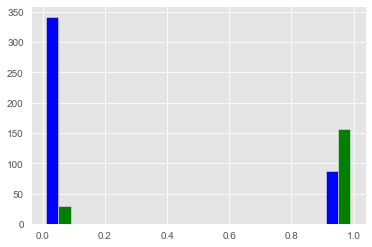

In [16]:
colors = ['b','g']
plt.hist([lalonde_df[lalonde_df['treat']==0]['black'],lalonde_df[lalonde_df['treat']==1]['black']],color=colors)


<h2>Propensity score matching using logistic regression</h2>

<h3>Exercise 3:</h3>
<h4>3.1</h4>
<p>Estimate the propensity scores using a logistic regression. Build a logistic regression model where the outcome variable is whether a subject was in the treatment group or not, and the covariates are all the other variables except <code>re78</code>. How would you interpret the predicted values output by the model? </p>

**Answer.**



-------

## With the coef hispan , for example,  when another coef has value 0, the probablity of hispan in the treatment is exp(coef of hispan)/(1+exp(coef of hispan)). This is also the Propensity score matching.


In [17]:
import statsmodels.api as sm

###  Because the data already converted to dummies varibles, we dont need to use get dummies.

In [18]:
la=ll
la.remove('re78')
df_log =lalonde_df[la]
df_log['Intercept'] = 1


In [19]:
logit_full1 = sm.Logit(lalonde_df['treat'], df_log)
logit_full1_res = logit_full1.fit()
print(logit_full1_res.summary())

Optimization terminated successfully.
         Current function value: 0.397267
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                  treat   No. Observations:                  614
Model:                          Logit   Df Residuals:                      605
Method:                           MLE   Df Model:                            8
Date:                Sun, 05 Dec 2021   Pseudo R-squ.:                  0.3508
Time:                        09:47:47   Log-Likelihood:                -243.92
converged:                       True   LL-Null:                       -375.75
Covariance Type:            nonrobust   LLR p-value:                 2.194e-52
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
age            0.0158      0.014      1.162      0.245      -0.011       0.042
educ           0.1613      0.

<h4>3.2</h4>
<p>Use <code>.predict()</code>  to obtain the propensity scores of individuals in our dataset. Save the the results with the name <code>pscore_logit</code> (these will be used later). In addition, make plots which show the distribution for both the treatment and control groups of propensity scores.</p>

**Answer.**

-------

In [20]:
pscore_logit=logit_full1_res.predict(df_log)
pscore_logit

NSW1       0.638770
NSW2       0.224634
NSW3       0.678244
NSW4       0.776324
NSW5       0.701639
             ...   
PSID425    0.123144
PSID426    0.034560
PSID427    0.183351
PSID428    0.383032
PSID429    0.089712
Length: 614, dtype: float64

<p>In order to balance the covariates of the control and treatment groups, we will use <strong>matching</strong>. Remember that we used matching in Case 7.5 to balance a population of prisoners to evaluate the effectiveness of a program aiming to reduce recidivism. Thus, the situation here is quite similar.</p>
<p>In Case 7.5 we used the <em>Euclidean distance</em> on the sample data to create the matching: for each individual of the treatment group, we would find the closest (in Euclidean distance) individual in the control group to match on. Although this method is attractive in general, we may have instances in which the balancing of some particular feature is more important than others. Say the employment program was aiming to create a positive impact within the Hispanic community and a higher proportion of individuals in the treatment group were Hispanic. The Euclidean distance would not take this into account, and we may end up comparing the effect of the treatment between Hispanics and other ethnicities.</p>
<p>We can alleviate this issue by using a metric that takes into account the characteristics of the treatment group. In this context, a metric called the <strong>propensity score</strong> helps us do the matching on select features in an efficient way. The key idea is that <em>the features that are correlated with the probability of a worker being selected into the treatment group affect our causal results</em>. A propensity score is this probability. The propensity score for subject $i$, denoted as $\pi_i$ is defined as:</p>
<p>$\pi_i$ = P(Subject $i$ is given training given their features $X_i$)</p>
<p>As an example, if a person had a propensity score of 0.3, that would mean that given their particular covariates, there was a 30% chance that they were placed in the treatment group. We can calculate this score by fitting a classification model to our data, where the input features are our covariates, and the output is whether that person was part of the treatment group or not.</p>

### Matching using $k$-nearest neighbors

We are going to match each treated subject with a control subject using nearest neighbors matching on the estimated propensity score. Here, we use another popular clustering algorithm: the **$k$-nearest neighbors ($k$-NN) algorithm**. This algorithm is quite similar to the one we used in Case 7.5. However, instead of finding the single control individual with the closest propensity score, it finds the $k$ control individuals with the closest propensity scores. The use of $k>1$ is handy for classification purposes: if each individual lies in a category, we can classify a new individual by finding its $k$ nearest neighbors and use the most common category of its neighbors as the selected category for the new individual. 

<h3>Exercise 4 :</h3>
<p>In this exercise, we will use the <code>sklearn.neighbors</code> function <a href="https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html#sklearn.neighbors.NearestNeighbors.kneighbors"><code>NearestNeighbors</code></a> to find, for each subject in the treatment group, the $k=5$ subjects in the control group with the closest propensity scores.</p>
<h4>4.1</h4>
<p>Separate the propensity scores <code>pscore_logit</code> found in Exercise 3 for treatment and control groups. Call these <code>treat_pscores</code> and <code>control_pscores</code> respectively. Use the <code>control_pscores</code> to train a $k$-NN algorithm with $k=5$.</p>
<p><strong>Hint:</strong> Load the model using <code>knn = neighbors.NearestNeighbors(n_neighbors=5,metric='euclidean')</code>. You may want to reshape the control scores using <code>control_pscores.reshape(-1,1)</code>.</p>

**Answer.**

-------

In [296]:
ll=pscore_logit.index

r=[x for x in ll if x[0]=="N"]
r1=[x for x in ll if x[0]=="P"]
treat_pscores=pscore_logit[r]
control_pscores=pscore_logit[r1]
control_pscores_ytrain=control_pscores.index
control_pscores_xtrain=control_pscores.values.reshape(-1,1)
from sklearn.neighbors import NearestNeighbors
knn.fit(control_pscores_xtrain)


NearestNeighbors(metric='euclidean')

<h4>4.2</h4>
<p>Find the indices of the five nearest neighbors using the method <code>.kneighbors()</code> applied to <code>treat_pscores</code>. </p>

**Answer.**

-------

In [300]:
treat_pscores_xtest=treat_pscores.values.reshape(-1,1)
A=knn.kneighbors(treat_pscores_xtest,n_neighbors=5, return_distance=False)


<h4>4.3</h4>
<p>Match the treatment and control groups using the closest of the five neighbors found above. Your output should be a pair of <code>DataFrames</code>, each with $185$ rows from the <code>lalonde_df</code>. The first should correspond to the treatment group and the second should correspond to the matched control group.</p>

**Answer.**

-------

In [301]:
m=[]
data = []
for i in range(0,185):
    m=[]
    for j in range(0,5):
       m.append(control_pscores.index[A[i][j]])
    data.append(m)
H=[]
H=pd.DataFrame (data)
H['treat group index']=treat_pscores.index
H


,0,1,2,3,4,treat group index
0,PSID69,PSID387,PSID373,PSID386,PSID376,NSW1
1,PSID111,PSID66,PSID339,PSID150,PSID199,NSW2
2,PSID370,PSID189,PSID268,PSID381,PSID355,NSW3
3,PSID226,PSID196,PSID118,PSID388,PSID412,NSW4
4,PSID140,PSID134,PSID277,PSID218,PSID372,NSW5
...,...,...,...,...,...,...
180,PSID239,PSID227,PSID420,PSID136,PSID17,NSW181
181,PSID76,PSID220,PSID127,PSID358,PSID91,NSW182
182,PSID380,PSID238,PSID6,PSID293,PSID24,NSW183
183,PSID24,PSID96,PSID380,PSID238,PSID6,NSW184


<h3>Propensity score distribution plot after matching</h3>
<p>Let's take a glance at the distribution of propensity score after matching. Both groups have similar distributions on the propensity score. This means we have reach a balance in both groups. This enables us to further analyze the causality effect of the treatment.</p>

<h3>Exercise 5 :</h3>
<p>Make a plot which shows the histograms of propensity scores for the control and treatment groups after matching. Compare your results with the plot in Exercise 3.2.</p>

**Answer.**

### The result from both groups are similar,but the histogram should have high bins numbers to see the similar results.

-------

### Historgram from treat group

(array([ 3.,  4.,  6.,  5.,  6.,  0.,  2.,  1.,  2.,  1.,  0.,  0.,  2.,
         4.,  1.,  4.,  0.,  4.,  4.,  9.,  8., 11., 16., 17., 16., 20.,
        19., 15.,  4.,  1.]),
 array([0.02495178, 0.05255849, 0.08016519, 0.10777189, 0.13537859,
        0.16298529, 0.190592  , 0.2181987 , 0.2458054 , 0.2734121 ,
        0.3010188 , 0.32862551, 0.35623221, 0.38383891, 0.41144561,
        0.43905231, 0.46665902, 0.49426572, 0.52187242, 0.54947912,
        0.57708582, 0.60469253, 0.63229923, 0.65990593, 0.68751263,
        0.71511934, 0.74272604, 0.77033274, 0.79793944, 0.82554614,
        0.85315285]),
 <BarContainer object of 30 artists>)

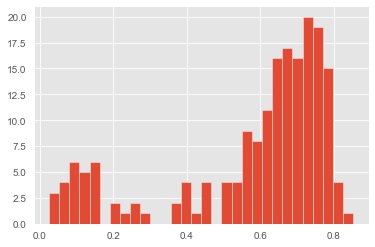

In [302]:
import matplotlib.pyplot as plt

plt.hist(treat_pscores,bins=30)

### Histrogram from Control Group in columns 1

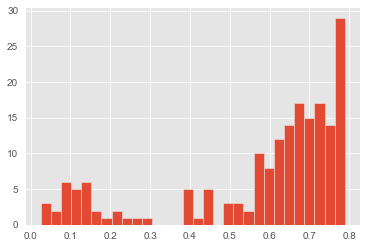

In [303]:
n=[]
for i in range(0,185):
       n.append(control_pscores[A[i][0]])
       
plt.hist(n,bins=30)
plt.show()

<h3>Exercise 6 :</h3>

Assess covariate balance after the $k$-NN matching.  For this, compute the absolute standardized differences in means in the covariates after matching,  $$ASMD_a(x)=\frac{\bar{x}_{t,a}-{\bar{x}_{c,a}}}{\sqrt{\frac{s^{2}_{t,b} + s^{2}_{c,b}}{2}}},$$ where $\bar{x}_{t,a}$ and $\bar{x}_{c,a}$ are, respectively, the means of covariate $x$ in the treatment and control groups after matching, and $s^{2}_{t,b}$ and $s^{2}_{c,b}$ are, correspondingly, the sample variances treatment and control groups before matching. 

One reason to use the sample variances before matching rather than the sample variances after matching is to free the comparisons of the means after matching from simultaneous changes in the variances. Comment on covariate balance.

**Answer.**

-------

### mean and var of control group after matching.

In [72]:
cga=lalonde_df.loc[H[1]].agg(['mean'])
del cga['treat']

### mean and var of treat group after matching.

In [73]:
tga=lalonde_df[lalonde_df['treat']==1].agg(['mean'])
del tga['treat']

#### numerical part

In [138]:
numerical=tga-cga
numerical


,age,educ,black,hispan,married,nodegree,re74,re75,re78
mean,0.221622,0.221622,0.005405,-0.010811,0.043243,-0.048649,-333.324158,159.468255,1745.242321


#### denominator part

In [97]:
diff

age                   educ               black            \
            mean         var       mean       var      mean       var   
treat                                                                   
0      28.030303  116.351883  10.235431  8.152387  0.202797  0.162048   
1      25.816216   51.194301  10.345946  4.042714  0.843243  0.132902   

         hispan             married            nodegree            \
           mean       var      mean       var      mean       var   
treat                                                               
0      0.142191  0.122258  0.512821  0.250419  0.596737  0.241204   
1      0.059459  0.056228  0.189189  0.154230  0.708108  0.207814   

              re74                       re75                       re78  \
              mean           var         mean           var         mean   
treat                                                                      
0      5619.236506  4.608714e+07  2466.484443  1.083724e+07  6984.169742   
1      2095.573689  2.387906e+07  1532.055314  1.036358e+07  6349.143530   

                     
                var  
treat                
0      5.320480e+07  
1      6.189602e+07

In [123]:
col=diff.sum()/2


In [132]:
denominator=col.to_frame().unstack()[0]['var'].apply(math.sqrt).to_frame().T

#### Calculate AMSD for each covariate.

In [145]:
numerical.reset_index(drop=True)/denominator.reset_index(drop=True)


,age,educ,black,hispan,married,nodegree,re74,re75,re78
0,0.024214,0.08975,0.014076,-0.036189,0.096138,-0.102672,-0.056356,0.048979,0.230055


<h3>Exercise 7 :</h3>
<p>Estimate the average effect of treatment on <font color='red'> wages (<code>re78</code>) </font> after matching. What do you conclude?</p>

### the p-value is smaller than 0.05. We can conclude that there is significantly difference of the average effect of treatment .

In [237]:
ca=lalonde_df.loc[H[1]]['re78']
ta=lalonde_df[lalonde_df['treat']==1]['re78']
test_stat, test_p=ttest_ind(ta,ca)
print(test_p)

0.015751561221641546


**Answer.**

-------

<h2>Propensity score matching using decision trees and random forests</h2>

<h3>Exercise 8 :</h3>
<p>To validate our propensity score calculations, let's try calculating them using other models such as decision trees and random forests.</p>

<h4>8.1</h4>
<p>Build a decision tree regressor where the outcome variable is whether a subject was in the treatment group or not, and the covariates are all the other variables except <code>re78</code>. Use the <code>sklearn.tree</code> function <code>DecisionTreeRegressor(max_depth=4)</code> and call the new propensity scores <code>pscore_tree</code>.</p>

**Answer.**

-------

In [163]:
import sklearn.tree

dectree=sklearn.tree.DecisionTreeRegressor(max_depth=4)
dectree.fit(df_log,lalonde_df['treat'])
pscore_tree=dectree.predict(df_log)


<h4>8.2</h4>
<p>Plot the decision tree regressor using the code</p>
<div class="codehilite"><pre><span></span><code><span class="err">fig = plt.gcf()</span>
<span class="err">fig.set_size_inches(150, 100)</span>
<span class="err">tree.plot_tree(dt,filled=True,feature_names=cleaned_df.columns)</span>
<span class="err">fig.savefig(&#39;tree.png&#39;)</span>
</code></pre></div>


<p>Replace <code>dt</code> with the name of the model created in Exercise 8.1. Use the plot to estimate the probability that a 24 year old, single, uneducated Hispanic individual that earned $\$20000$ in 1974 was enrolled in the employment program. Do the same with a black man with the same characteristics. (Assume that there were no black Hispanics in the study.)</p>

**Answer.**

-------

#### 0.083 (the probability that a 24 year old, single, uneducated Hispanic individual that earned $\$20000$ in 1974 was enrolled in the employment program)



#### 0.865 ( the same with a black man with the same characteristics)

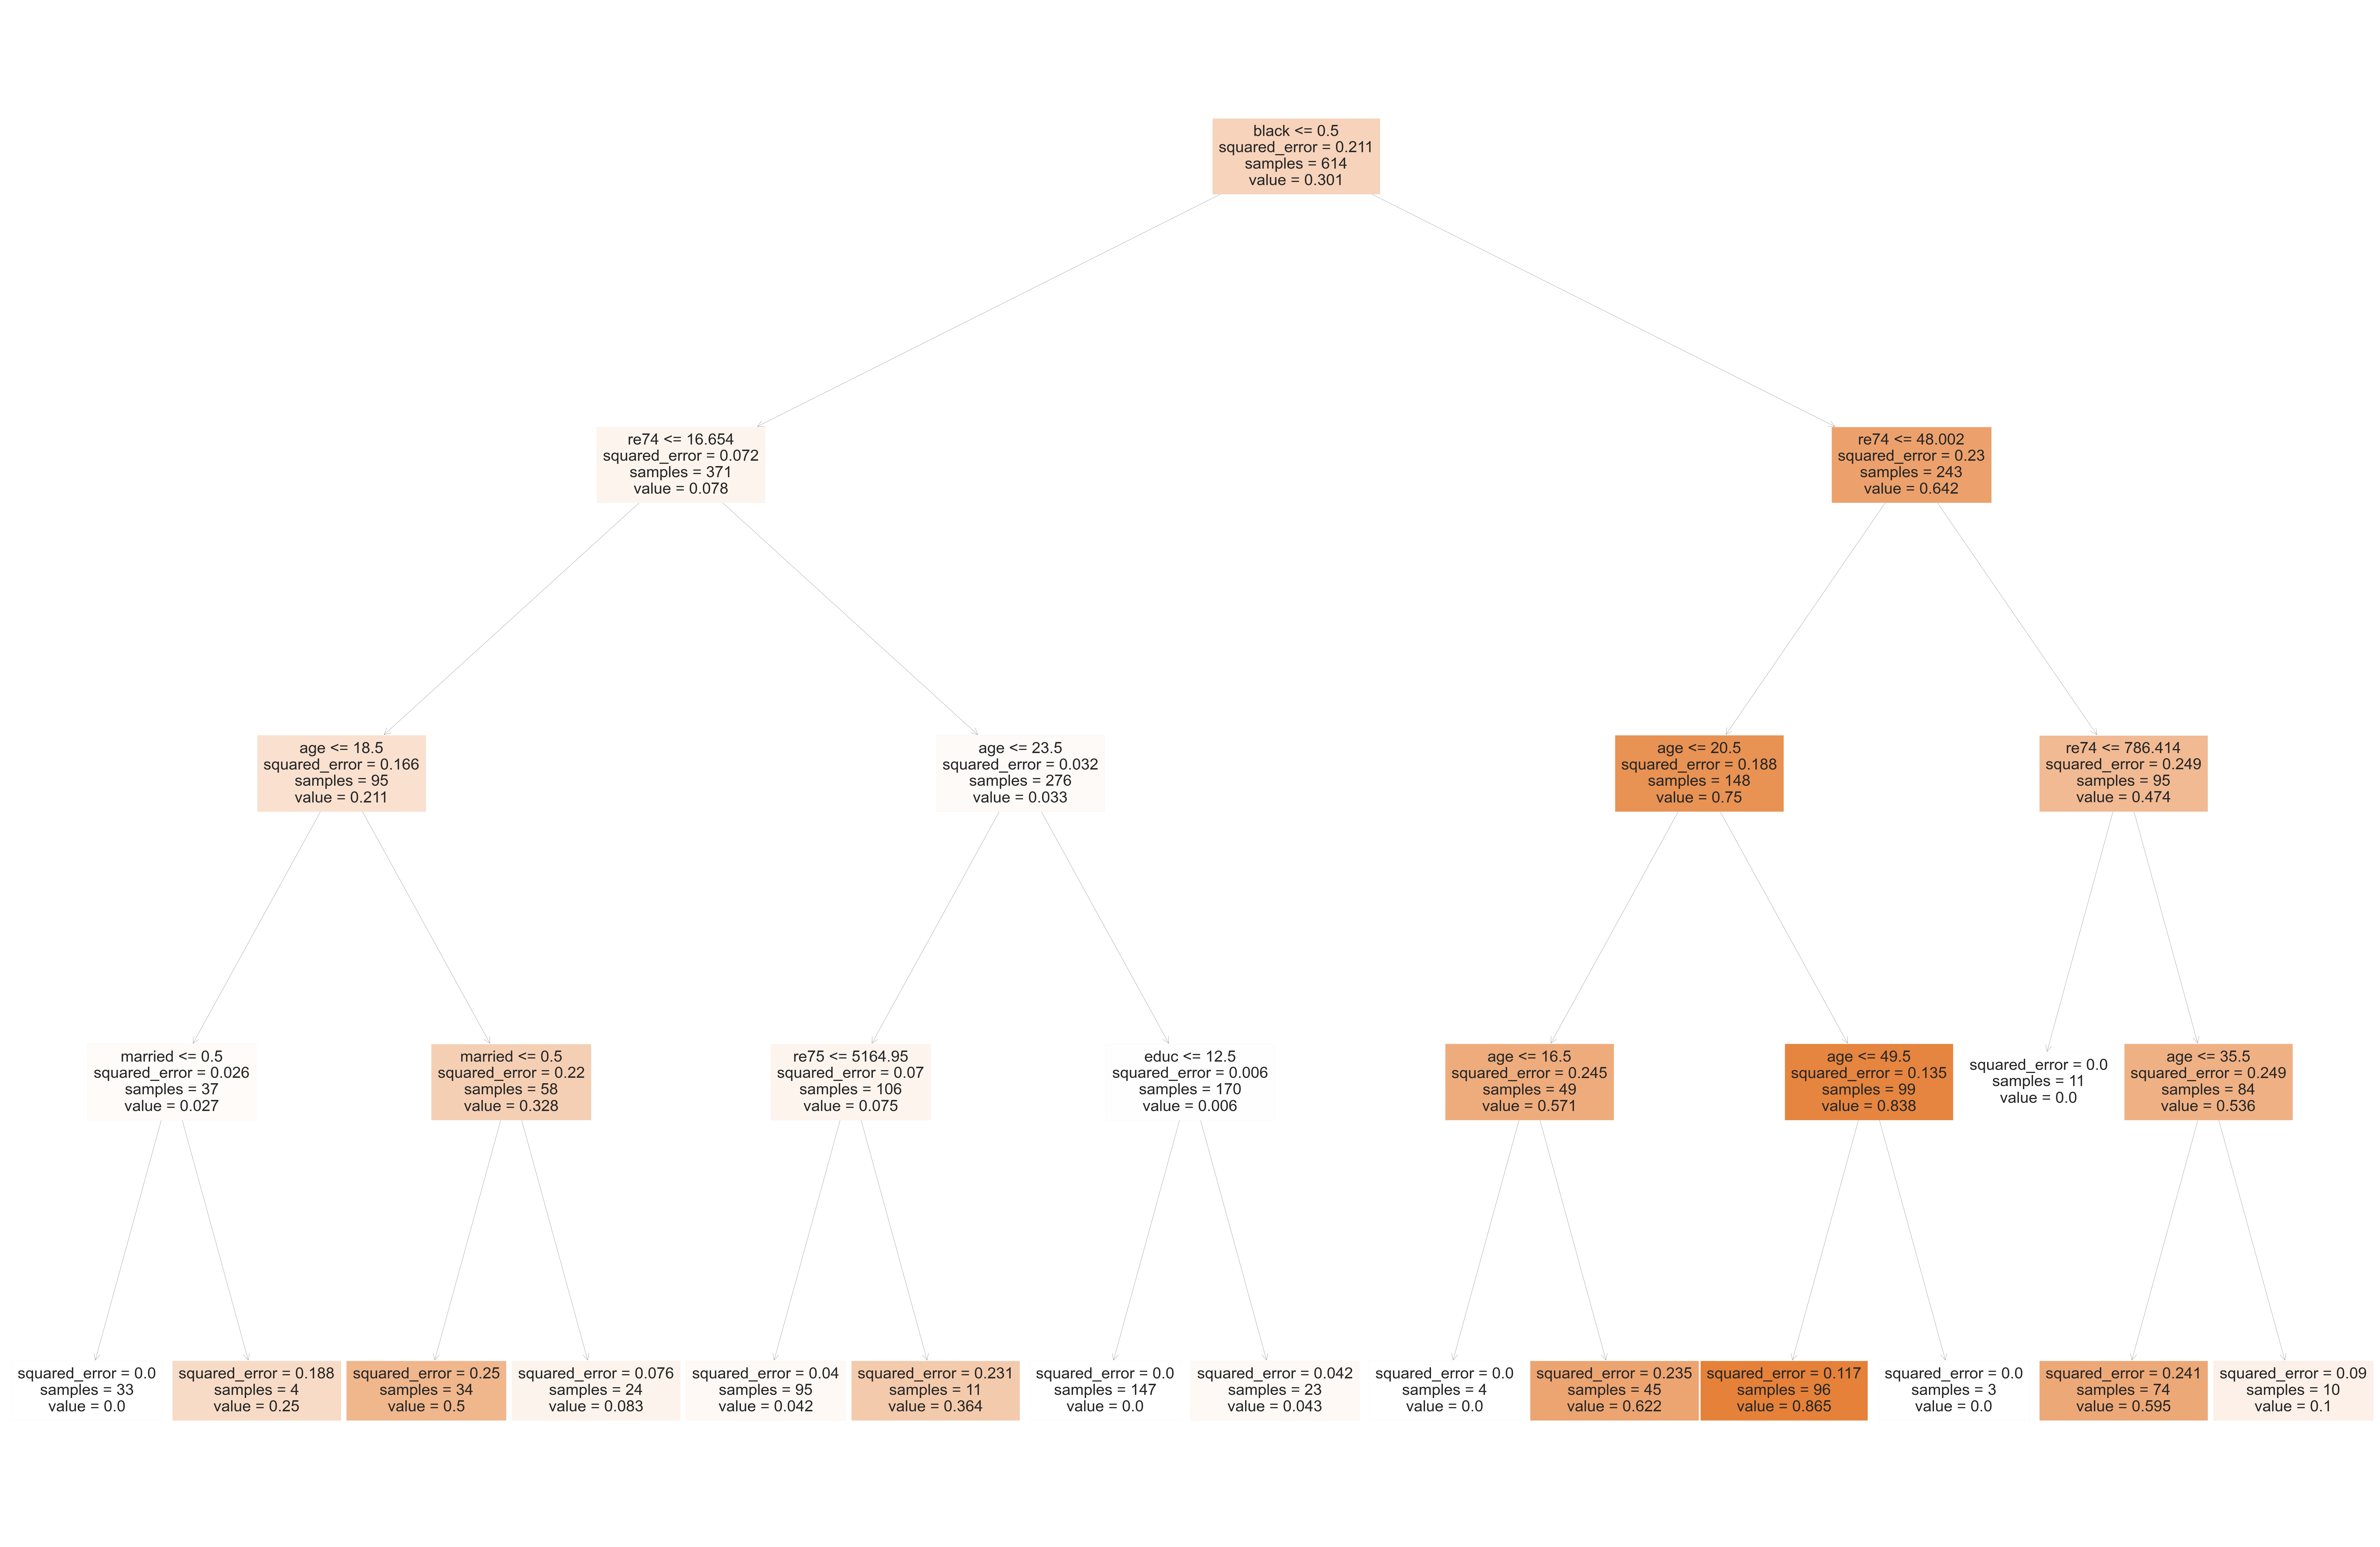

In [169]:
fig=plt.gcf()
fig.set_size_inches(150,100)
tree.plot_tree(dectree,filled=True,feature_names=df_log.columns)
fig.savefig('tree.png')


<h4>8.3</h4>
<p>Estimate the propensity scores now by using random forests. For the model, use the <code>sklearn.ensemble</code> function <code>RandomForestClassifier</code> with parameters <code>n_estimators=100, max_depth=4, random_state=42</code>. Then, use the method <code>predict_proba</code> to extract the propensity scores. Name the scores <code>pscore_forest</code>.</p>

**Answer.**

-------

In [189]:
fores=sklearn.ensemble.RandomForestClassifier(n_estimators=100,max_depth=4, random_state=42)
fores.fit(df_log,lalonde_df['treat'])
pscore_forest=fores.predict_proba(df_log)[:,1]


<h4>8.4</h4>
<p>Make a plot with the three ROC curves corresponding to the logistic regression, decision tree, and random forest classifiers used to compute the propensity scores. What is the AUC of each model? Which model <em>seems</em> to do the best job?</p>

**Answer.**

-------
The AUC of Random forest,decision tree, logistic , respectively:
0.9330624330624332; 0.8742266742266742; 0.8742266742266742


The decision tree did the best job

In [ ]:
pd.concat(pd.Series(pscore_forest),pd.Series(pscore_tree))

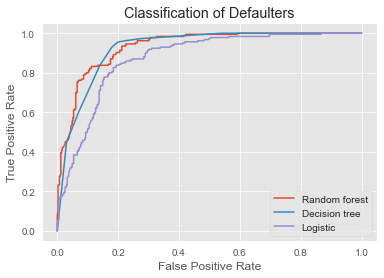

In [223]:
from sklearn.metrics import roc_curve, auc, accuracy_score
roc_pf= roc_curve(lalonde_df['treat'],pscore_forest.tolist())
roc_ptree = roc_curve(lalonde_df['treat'],pscore_tree.tolist())
roc_plo = roc_curve(lalonde_df['treat'],pscore_logit.tolist())

plt.plot(roc_pf[0], roc_pf[1],label='Random forest')
plt.plot(roc_ptree[0], roc_ptree[1],label='Decision tree')
plt.plot(roc_plo[0], roc_plo[1],label='Logistic')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Classification of Defaulters')
plt.legend(loc='lower right')
plt.show()

In [228]:
from sklearn.metrics import roc_auc_score
f_auc = roc_auc_score(lalonde_df['treat'],pscore_forest.tolist())
d_auc = roc_auc_score(lalonde_df['treat'],pscore_tree.tolist())
d_auc = roc_auc_score(lalonde_df['treat'],pscore_logit.tolist())

print(f_auc,d_auc,d_auc)

0.9330624330624332 0.8742266742266742 0.8742266742266742


<h4>8.5</h4>
<p>Consider the following statement:</p>
<blockquote>
<p>"<em>A model with a higher AUC provides much better estimates of the true propensity scores. In particular, a matching using the propensity scores of such a model will balance the covariates much better.</em>"</p>
</blockquote>
<p>Is the statement true or false? Explain. </p>

**Answer.**

-------

It is not allways true. For example ,in this case, the above  statement is wrong. Auc is used to obtain the area under the ROC curve.At low fall positive rate, the random forest could perform better than another model, but at high fall positive, it is worser than Decision tree regression.

<h4>8.6</h4>
<p>Repeat the matching procedure now with the estimated propensity scores <code>pscore_tree</code> and <code>pscore_forest</code>. Assess the covariate balances and estimate the average effect of treatment on wages (<code>re78</code>) after matching. Compare your results. </p>

**Answer.**

-------

In [276]:
treat_pscores=pscore_tree[0:185]
control_pscores=pscore_tree[186:]

control_pscores_xtrain=control_pscores.reshape(-1,1)
from sklearn.neighbors import NearestNeighbors
knn.fit(control_pscores_xtrain)


treat_pscores_xtest=treat_pscores.reshape(-1,1)
A=knn.kneighbors(treat_pscores_xtest,n_neighbors=5, return_distance=False)

In [368]:
def matchpro(proseries):
    treat_pscores=proseries[0:185]
    control_pscores=proseries[186:]

    control_pscores_xtrain=control_pscores.reshape(-1,1)
    from sklearn.neighbors import NearestNeighbors
    knn.fit(control_pscores_xtrain)


    treat_pscores_xtest=treat_pscores.reshape(-1,1)
    A=knn.kneighbors(treat_pscores_xtest,n_neighbors=5, return_distance=False)
    return A


In [369]:
dff=lalonde_df[lalonde_df['treat']==0]
dff=dff.reset_index(drop=True)

### p value for decision tree

In [370]:
ind=matchpro(pscore_tree)[:,0]
dffa=dff.iloc[ind]


In [371]:
ca=dffa['re78']
ta=lalonde_df[lalonde_df['treat']==1]['re78']
test_stat, test_p=ttest_ind(ta,ca)
print(test_p)

0.4647961948024161


#### p value for random forest

In [372]:
ind=matchpro(pscore_forest)[:,0]
dffa=dff.iloc[ind]
ca=dffa['re78']
ta=lalonde_df[lalonde_df['treat']==1]['re78']
test_stat, test_p=ttest_ind(ta,ca)
print(test_p)

0.48254773136917695


<h4>8.7</h4>
<p>Why do you think the decision tree regressor performed badly on balancing the covariates of the treat and control groups?  </p>
<p><strong>Hint:</strong> Look at the distances of the ten nearest neighbors output by <code>.kneighbors()</code> for the propensity scores of the decision tree model. What do you see? Why do you think these distances may have an impact on balancing?</p>

**Answer.**

-------

There is some points which has very high distance. When the disctance increasse, the accuracy of matching descreasse.Therefore, the balancing is bad with the decision tree.

In [374]:
def matchprodistance(proseries):
    treat_pscores=proseries[0:185]
    control_pscores=proseries[186:]

    control_pscores_xtrain=control_pscores.reshape(-1,1)
    from sklearn.neighbors import NearestNeighbors
    knn.fit(control_pscores_xtrain)


    treat_pscores_xtest=treat_pscores.reshape(-1,1)
    A=knn.kneighbors(treat_pscores_xtest,n_neighbors=10, return_distance=True)
    return A

In [378]:
matchprodistance(pscore_tree)

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([[187, 421, 366, ..., 398, 397, 291],
        [222, 383, 369, ..., 175, 154, 381],
        [187, 421, 366, ..., 398, 397, 291],
        ...,
        [ 44, 132,  95, ...,   3,   6,  97],
        [ 44, 132,  95, ...,   3,   6,  97],
        [ 44, 132,  95, ...,   3,   6,  97]], dtype=int64))